``` python
# if you running at azure nootbook to prepare env
#!pip install lxml --ignore-installed lxml
#!pip install tushare==1.2.54 
```

In [1]:
from sklearn.cluster import KMeans

from greenseer.plots.boundary_plots import plot_gaussian_mixture_boundaries
from greenseer.plots.knife_plots import plot_knife
%load_ext autoreload
%autoreload 2

In [2]:
from logging.config import fileConfig

import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline

from greenseer.configuration import do_global_configuration
from greenseer.dataset.china_dataset import TRAIN_SET_ALL, fetch_train_set
from greenseer.preprocessing.clean_data import remove_inf_and_na, RemoveAbnormalFilter
from greenseer.preprocessing.transformers import regular_expression_column_filter, \
    pick_annual_report_china, append_industry_transform, re_percent_column_transform
from greenseer.utils.tools import save_fig, save_csv
%matplotlib inline

do_global_configuration("config.properties")
fileConfig('logging_config.ini')



In [3]:
from greenseer.plots.normal_plots import DistributeGramEntry, plot_distribute_gram
from greenseer.plots.violin_plots import plot_violin_plot_with_color, ViolinInfos
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm
from pylab import mpl
font_path = 'SourceHanSerifSC-ExtraLight.otf'
prop = mfm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'Source Han Serif SC'
mpl.rcParams['font.sans-serif'] = ['Source Han Serif SC'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

- 600519：茅台

In [58]:
# reports = fetch_multi_report(stock_ids=np.array(["600519","600520"]))
reports = fetch_train_set(TRAIN_SET_ALL)

In [59]:
reports.index.get_level_values(1)

DatetimeIndex(['2020-03-31', '2019-12-31', '2019-06-30', '2018-12-31',
               '2017-12-31', '2016-12-31', '2019-03-31', '2020-03-31',
               '2019-12-31', '2019-06-30',
               ...
               '2019-06-30', '2018-12-31', '2018-09-30', '2017-12-31',
               '2017-06-30', '2016-12-31', '2016-06-30', '2015-12-31',
               '2014-12-31', '2013-12-31'],
              dtype='datetime64[ns]', name='releaseAt', length=157477, freq=None)

In [60]:
reports.loc['600519']['2018']

,一年内到期的非流动负债(万元),一年内到期的非流动资产(万元),一般风险准备(万元),专项储备(万元),专项应付款(万元),买入返售金融资产(万元),交易性金融负债(万元),交易性金融资产(万元),代理买卖证券款(万元),代理承销证券款(万元),...,购买商品、接受劳务支付的现金(万元),购建固定资产、无形资产和其他长期资产所支付的现金(万元),资产减值准备(万元),递延所得税负债增加(万元),递延所得税资产减少(万元),递延收益增加(减：减少)(万元),销售商品、提供劳务收到的现金(万元),长期待摊费用摊销(万元),预提费用的增加(万元),预计负债(万元)
releaseAt,,,,,,,,,,,,,,,,,,,,,
2018-12-31,0.0,0.0,78830.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,529852.0,160675.0,129.0,0.0,35250.0,0.0,8426870.0,1033.0,0.0,0.0
2018-09-30,0.0,0.0,60086.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,367636.0,101648.0,0.0,0.0,0.0,0.0,5761933.0,0.0,0.0,0.0
2018-06-30,0.0,0.0,60086.0,0.0,1557.0,0.0,0.0,0.0,0.0,0.0,...,227664.0,71664.0,122.0,0.0,18566.0,0.0,3461149.0,506.0,0.0,0.0
2018-03-31,0.0,0.0,60086.0,0.0,1557.0,0.0,0.0,0.0,0.0,0.0,...,134139.0,57464.0,0.0,0.0,0.0,0.0,1936609.0,0.0,0.0,0.0


In [5]:
subjects = [r'\w*应付\w*|\w*应收\w*|存货|货币资金|\w*生物\w*|\w*资产总计\w*']
final_subjects = [r'industry|payable|receivable|base']
payable_subject = 'payable'
receivable_subject = 'receivable'

prepare_pipeline = Pipeline([
        ('pick_annual_report', pick_annual_report_china()),
        ('pick_subject', regular_expression_column_filter(patterns=subjects,rename={"资产总计(万元)":"base"})),
        ('percent payable', re_percent_column_transform(numerator=[r'\w*应付\w*'], denominator=[r'base'],new_name=payable_subject)),
        ('percent receivable', re_percent_column_transform(numerator=[r'\w*应收\w*'], denominator=[r'base'],new_name=receivable_subject)),
        ('append industry',append_industry_transform()),
        ('clean data',remove_inf_and_na()),
        ('pick_final_subject', regular_expression_column_filter(patterns=final_subjects)),
        ('remove abnormal',RemoveAbnormalFilter([payable_subject, receivable_subject],quantile=0.98,mode="high"))

])

data = prepare_pipeline.fit_transform(reports)

In [6]:
summary_by_category = data.groupby("industry")
mean= summary_by_category.mean()

Saving figure attribute_histogram_plots
Saving scv: ./csv/test.csv
Saving scv: ./csv/all.csv


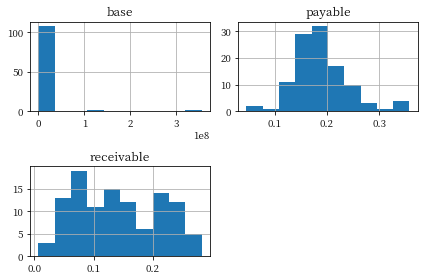

In [7]:
mean.hist()
save_fig("attribute_histogram_plots")
save_csv(data=mean,name="test")
save_csv(data=data,name="all")

Saving scv: ./csv/industry_group.csv
Saving figure industry_group


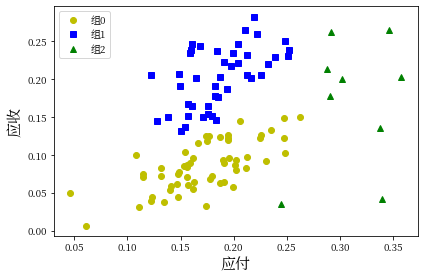

In [8]:
X = mean[[payable_subject,receivable_subject]].values

industry_model = GaussianMixture(n_components=3,n_init=10)
y_pred = industry_model.fit(X).predict(X)
mean["group"] = y_pred
save_csv(data=mean,name="industry_group")

plot_data = [
    DistributeGramEntry(x=X[y_pred==0, 0],y= X[y_pred==0, 1],fmt="yo",label="组0"),
    DistributeGramEntry(x=X[y_pred==1, 0],y= X[y_pred==1, 1],fmt="bs",label="组1"),
    DistributeGramEntry(x=X[y_pred==2, 0],y= X[y_pred==2, 1],fmt="g^",label="组2"),
]
subject_label = ["应付","应收"]
plot_distribute_gram(plt,plot_data,subject_label)
save_fig("industry_group")
plt.show()

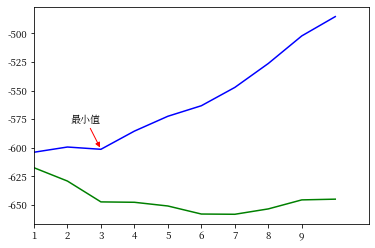

In [9]:
industry_models = [GaussianMixture(n_components=k,n_init=10).fit(X) for k in range(1,11)]
bics = [model.bic(X) for model in industry_models]
aics = [model.aic(X) for model in industry_models]

plt.plot(range(1,11),bics,"b")
plt.plot(range(1,11),aics,"g")
plt.xlim((1,11))
plt.xticks(range(1,10))
plt.annotate('最小值', xy=(3, bics[2]),xytext=(3,bics[2]+30),
             arrowprops=dict(arrowstyle='-|>',connectionstyle='arc3',color='red'),
            horizontalalignment='right', verticalalignment='top'
            )
plt.show()

In [10]:
company = data[[payable_subject, receivable_subject]].values
industry = mean[[payable_subject,receivable_subject]].values

Saving figure received_payable_distribute


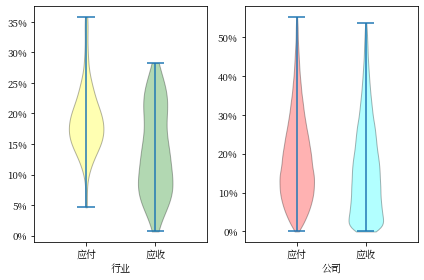

In [11]:
fig, (ax1,ax2)= plt.subplots(1,2)

plot_violin_plot_with_color(ax1,industry,"行业",ViolinInfos(["应付","应收"],["yellow","green"]),y_to_percent=True)
plot_violin_plot_with_color(ax2,company,"公司",ViolinInfos(["应付","应收"],["red","cyan"]),y_to_percent=True)

save_fig("received_payable_distribute")
plt.show()

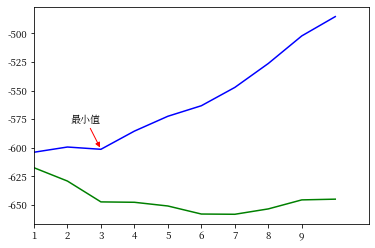

In [12]:
X = company
company_models = [GaussianMixture(n_components=k,n_init=10).fit(X) for k in range(1,11)]
plt.plot(range(1,11),bics,"b")
plt.plot(range(1,11),aics,"g")
plt.xlim((1,11))
plt.xticks(range(1,10))
plt.annotate('最小值', xy=(3, bics[2]),xytext=(3,bics[2]+30),
             arrowprops=dict(arrowstyle='-|>',connectionstyle='arc3',color='red'),
            horizontalalignment='right', verticalalignment='top'
            )
plt.show()

Saving scv: ./csv/company_group.csv
Saving figure company_group


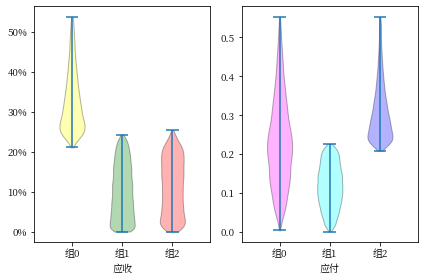

In [13]:
company_model = company_models[2]
y_pred =  company_model.predict(X)
gs_data = data.copy()

gs_data["group"] = y_pred
save_csv(data=data,name="company_group")

fig,(ax1,ax2)= plt.subplots(1,2)

display = gs_data[["group",receivable_subject]].groupby("group").indices
receive_subject = [gs_data.iloc[display[0]][receivable_subject],gs_data.iloc[display[1]][receivable_subject], gs_data.iloc[display[2]][receivable_subject]]
plot_violin_plot_with_color(ax1,receive_subject,"应收",ViolinInfos(["组0","组1","组2"],["yellow","green","red"]),y_to_percent=True)

display = gs_data[["group",payable_subject]].groupby("group").indices
payable_subject_list = [gs_data.iloc[display[0]][payable_subject],gs_data.iloc[display[1]][payable_subject], gs_data.iloc[display[2]][payable_subject]]
plot_violin_plot_with_color(ax2,payable_subject_list,"应付",ViolinInfos(["组0","组1","组2"],["magenta","cyan","blue"]))

save_fig("company_group")
plt.show()


In [14]:
company_proba = company_model.predict_proba(X)
gs_data["group0_proba"]= company_proba[:,0]
gs_data["group1_proba"]= company_proba[:,1]
gs_data["group2_proba"]= company_proba[:,2]


abnormal1 = gs_data.loc[(gs_data['group'] == 0) & (gs_data["group0_proba"] <= 0.5)]

In [15]:
abnormal2 = gs_data.loc[(gs_data['group'] == 1) & (gs_data["group1_proba"] <= 0.5)]

In [16]:
abnormal3 = gs_data.loc[(gs_data['group'] == 2) & (gs_data["group2_proba"] <= 0.5)]

In [17]:
abnormal = pd.concat([abnormal1,abnormal2,abnormal3])
save_csv(abnormal,"abnormal_gs")


Saving scv: ./csv/abnormal_gs.csv


Saving scv: ./csv/all_company_with_prob.csv
Saving figure knife_company


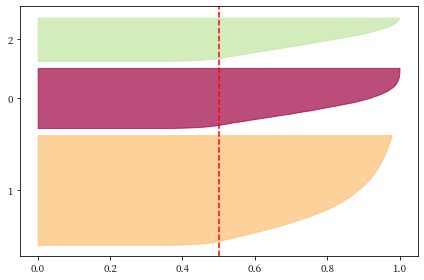

In [18]:
plot_knife(plt,gs_data)
save_csv(abnormal,"all_company_with_prob")
save_fig("knife_company")
plt.show()

/Users/chandlersong/oneDrive/code/greenseer/greenseer/plots/boundary_plots.py:62: UserWarning: The following kwargs were not used by contour: 'cm'
  levels=np.logspace(0, 2, 12))
/Users/chandlersong/oneDrive/code/greenseer/greenseer/plots/boundary_plots.py:67: UserWarning: The following kwargs were not used by contour: 'cm'
  linewidths=1, colors='k')


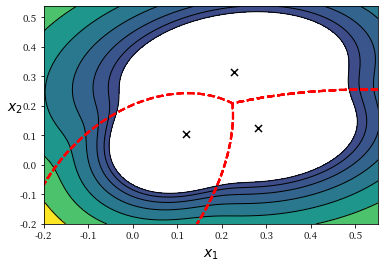

In [19]:
plot_gaussian_mixture_boundaries(plt,company_model,(X.min(axis=0) - 0.1,X.max(axis=0) - 0.1),cm=plt.cm.Set1)
plt.show()

/Users/chandlersong/oneDrive/code/greenseer/greenseer/plots/boundary_plots.py:62: UserWarning: The following kwargs were not used by contour: 'cm'
  levels=np.logspace(0, 2, 12))
/Users/chandlersong/oneDrive/code/greenseer/greenseer/plots/boundary_plots.py:67: UserWarning: The following kwargs were not used by contour: 'cm'
  linewidths=1, colors='k')


Saving figure industry_pro_diatribe


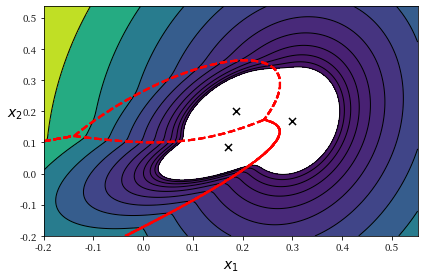

In [20]:
plot_gaussian_mixture_boundaries(plt,industry_models[2],(X.min(axis=0) - 0.1,X.max(axis=0) - 0.1))
save_fig("industry_pro_diatribe")
plt.show()

In [21]:
payable_subject = 'payable'
receivable_subject = 'receivable'
industry_means = mean[[payable_subject,receivable_subject]]
X = data[[payable_subject, receivable_subject]].values


km_models = KMeans(n_clusters=len(industry_means),init=industry_means)
y_pred = km_models.fit_predict(X)

/Users/chandlersong/.conda/envs/Normal/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1008: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return self.fit(X, sample_weight=sample_weight).labels_


Saving scv: ./csv/kmeans_industry_info.csv
Saving figure kmeans_industry_info


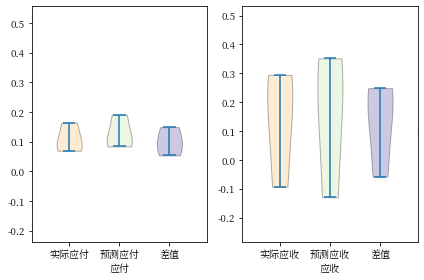

In [22]:
km_means = mean.copy()
pred_means = km_models.cluster_centers_
km_means["payable_pred"] = pred_means[:,0]
km_means["receivable_pred"] = pred_means[:,1]
km_means["payable_gap"] = km_means[payable_subject]-km_means["payable_pred"]
km_means["receivable_gap"] = km_means[receivable_subject]-km_means["receivable_pred"]


fig, (ax1,ax2)= plt.subplots(1,2)

payable_means = km_means[[payable_subject,"payable_pred","payable_gap"]]
receiveable_means = km_means[[receivable_subject,"receivable_pred","receivable_gap"]]
plot_violin_plot_with_color(ax1,payable_means,"应付",ViolinInfos(["实际应付","预测应付","差值"]))
plot_violin_plot_with_color(ax2,receiveable_means,"应收",ViolinInfos(["实际应收","预测应收","差值"]))
save_csv(km_means,"kmeans_industry_info")
save_fig("kmeans_industry_info")
plt.show()


In [23]:
km_data = data.copy()
km_data["p_pred"] = y_pred
industry_dict = km_means.reset_index()[["industry"]].reset_index()
industry_dict_pred = industry_dict.copy()
industry_dict_pred.columns=["p_pred","predict_industry"]
diff_data = pd.merge(km_data.reset_index(), industry_dict_pred,
      on="p_pred",how='left')

save_csv(diff_data,"prediction_company_industry")
same_as_predict_company = diff_data.loc[diff_data["industry"]==diff_data["predict_industry"]]

Saving scv: ./csv/prediction_company_industry.csv
